In [9]:
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
env = gym.make("CartPole-v1")

In [12]:
ACTION_SIZE = env.action_space.n
STATE_SIZE = env.observation_space.shape[0]

NUM_EPISODES = 1000
LEARNING_RATE = 0.001
DISCOUNT_FACTOR = 0.95

In [13]:
class ReinforceNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(ReinforceNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [14]:
def discount_rewards(episode_rewards, discount_factor):
    discounted_rewards = np.zeros_like(episode_rewards)
    cumulative_reward = 0
    for i in reversed(range(len(episode_rewards))):
        cumulative_reward = episode_rewards[i] + discount_factor * cumulative_reward
        discounted_rewards[i] = cumulative_reward
    return discounted_rewards


def normalize_rewards(episode_rewards):
    return (episode_rewards - np.mean(episode_rewards)) / (
        np.std(episode_rewards) + 1e-9
    )

In [ ]:
def train(
    model: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
    env: gym.Env,
    num_episodes: int,
    discount_factor: float,
):
    reward_history = []
    action_history = dict()
    for episode_idx in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_rewards, episode_log_probs, episode_actions = [], [], []
        while not done:
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            action_log_probs = model(state).squeeze(0)
            action_probs = torch.exp(action_log_probs)
            action = np.random.choice(
                range(ACTION_SIZE), p=action_probs.detach().cpu().numpy()
            )

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state

            episode_log_probs.append(action_log_probs[action])
            episode_rewards.append(reward)
            episode_actions.append(action)

        discounted_normalized_rewards = torch.tensor(
            normalize_rewards(discount_rewards(episode_rewards, discount_factor)),
            dtype=torch.float32,
            device=device,
        )
        loss = -torch.mean(
            torch.stack(episode_log_probs) * discounted_normalized_rewards
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reward_history.append(sum(episode_rewards))

        if episode_idx % 50 == 0:
            print(
                f"Episode {episode_idx}, Total Reward: {sum(episode_rewards)}, Loss: {loss.item()}"
            )

        if episode_idx % (num_episodes // 4) == 0 or episode_idx == num_episodes - 1:
            torch.save(model.state_dict(), f"reinforce_{episode_idx}.pth")

    return reward_history, action_history

In [16]:
model = ReinforceNetwork(STATE_SIZE, ACTION_SIZE).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
env = gym.make("CartPole-v1")
rewards, actions = train(model, optimizer, device, env, NUM_EPISODES, DISCOUNT_FACTOR)

Episode 0, Total Reward: 21.0, Loss: 0.0026922679971903563
Episode 50, Total Reward: 15.0, Loss: -0.030536700040102005
Episode 100, Total Reward: 24.0, Loss: 0.008417867124080658
Episode 150, Total Reward: 36.0, Loss: 0.0021750926971435547
Episode 200, Total Reward: 36.0, Loss: 0.0031592051964253187
Episode 250, Total Reward: 69.0, Loss: -0.005775099154561758
Episode 300, Total Reward: 67.0, Loss: 0.00578649714589119
Episode 350, Total Reward: 98.0, Loss: -0.03998344764113426
Episode 400, Total Reward: 47.0, Loss: 0.037820566445589066
Episode 450, Total Reward: 128.0, Loss: 0.023291632533073425
Episode 500, Total Reward: 142.0, Loss: -0.07342302799224854
Episode 550, Total Reward: 128.0, Loss: 0.005732908844947815
Episode 600, Total Reward: 166.0, Loss: -0.0929250717163086
Episode 650, Total Reward: 294.0, Loss: -0.023806285113096237
Episode 700, Total Reward: 339.0, Loss: -0.005217784084379673
Episode 750, Total Reward: 270.0, Loss: -0.007431273814290762
Episode 800, Total Reward: 237

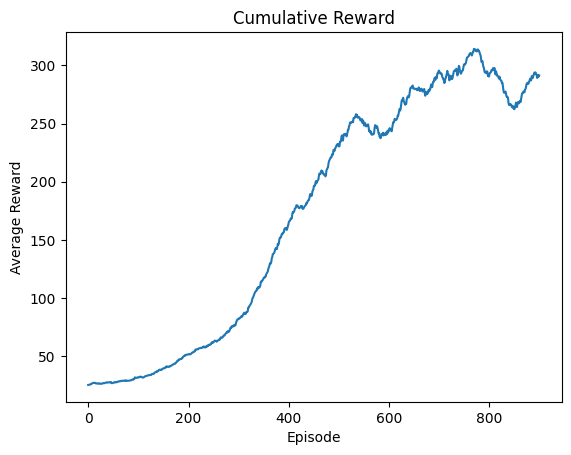

In [17]:
avg_rewards = [np.mean(rewards[i - 100 : i]) for i in range(100, len(rewards))]
plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Cumulative Reward")
plt.show()

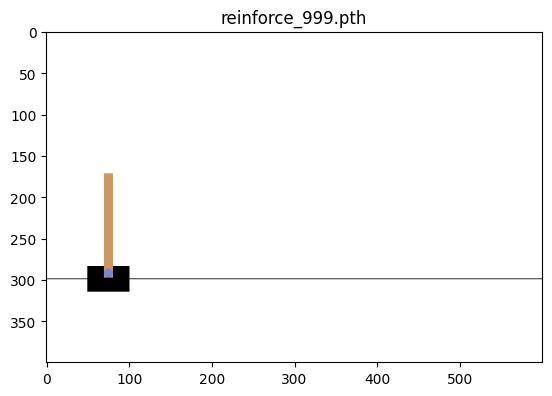

In [20]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

for model_file in sorted(
    list(Path(".").glob("reinforce_*.pth")), key=lambda x: int(x.stem.split("_")[1])
):
    print(model_file)
    model = ReinforceNetwork(STATE_SIZE, ACTION_SIZE).to(device)
    model.load_state_dict(torch.load(model_file))
    model.eval()

    env = gym.make("CartPole-v1", render_mode="rgb_array")
    state, _ = env.reset()
    done = False
    img = plt.imshow(env.render())
    plt.title(model_file)
    while not done:
        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)

        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = torch.argmax(model(state)).item()
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        time.sleep(1 / 60)
    env.close()